In [16]:
import os
import json
import matplotlib.pyplot as plt
import glob
import seaborn as sns

def filter_json_files(
    directory: str,
    included_keys: list = None,
    excluded_keys: list = None,
    must_include: list = None,
    verbose=False
) -> list:
    """
    根据给定的条件过滤 JSON 文件。
    
    :param directory: 包含 JSON 文件的目录路径。
    :param included_keys: 包含这些关键字的文件将被保留。
    :param excluded_keys: 包含这些关键字的文件将被排除。
    :param must_include: 必须包含这些关键字的文件才会被保留。
    :return: 过滤后的 JSON 文件列表。
    """
    json_files = glob.glob(f'{directory}/*.json')
    all_json_files = json_files

    
    if included_keys:
        json_files = [f for f in json_files if any([x in f for x in included_keys])]
        if verbose:
            print("included_keys:")
            print(json_files)
    if excluded_keys:
        json_files = [f for f in json_files if all([x not in f for x in excluded_keys])]
        if verbose:
            print("excluded_keys:")
            print(json_files)
    if must_include:
        json_files = [f for f in json_files if all([x in f for x in must_include])]
        if verbose:
            print("must_include:")
            print(json_files)
    for f in all_json_files:
        if 'bs_32768_lion_mean_lr_1e-5_star7L_d1024_scale20_negbias10_TS' in f:
            print(f)
            json_files.append(f)


    return json_files

def get_marker_by_text_model(name, by_bs=False):
    if by_bs:
        if '50000' in name:
            return 'o'
        else:
            return '+'
    else:
        if 'gte' in name:
            return 'o'
        elif 'Qwen1.5b' in name:
            return 's'
        elif 'Qwen7b' in name:
            return '*'
        else:
            return '+'


ms = 6 # marker size

# 推荐主题：seaborn 默认主题
# sns.set_theme(style="whitegrid")
sns.set_theme(style="whitegrid", palette="bright")
# plt.style.use('seaborn')

# 自定义matplotlib参数
custom_params = {
    'figure.figsize': (10, 6),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'legend.fontsize': 'medium',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.grid': True,
    'font.family': 'serif'
}

plt.rcParams.update(custom_params)

def read_json_file(json_file):
    try:
        with open(json_file, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"File {json_file} not found.")
        return None
    except json.JSONDecodeError:
        print(f"File {json_file} is not a valid JSON.")
        return None

must_include = None 
included_keys = None
excluded_keys = None

# 示例用法

included_keys = ['gtendinoL','star7','cc3m']
excluded_keys = ['amb','slin','sub','llava','mixed','d1536','600','Qwen7b','test','SV','LA','coco','rand',"sampleneg","50000","gmp","TS","XL"]
# must_include = ['llava_vflan',"star"]·
must_include = ["star",'cc','gte','raw','multi_postext_s2']



## Imagenet V1

/home/mila/l/le.zhang/scratch/light_align/evaluation/eval_result/imagenetv1/cc3mraw_gtendinoL/bs_32768_lion_mean_lr_1e-5_star7L_d1024_scale20_negbias10_TS.json


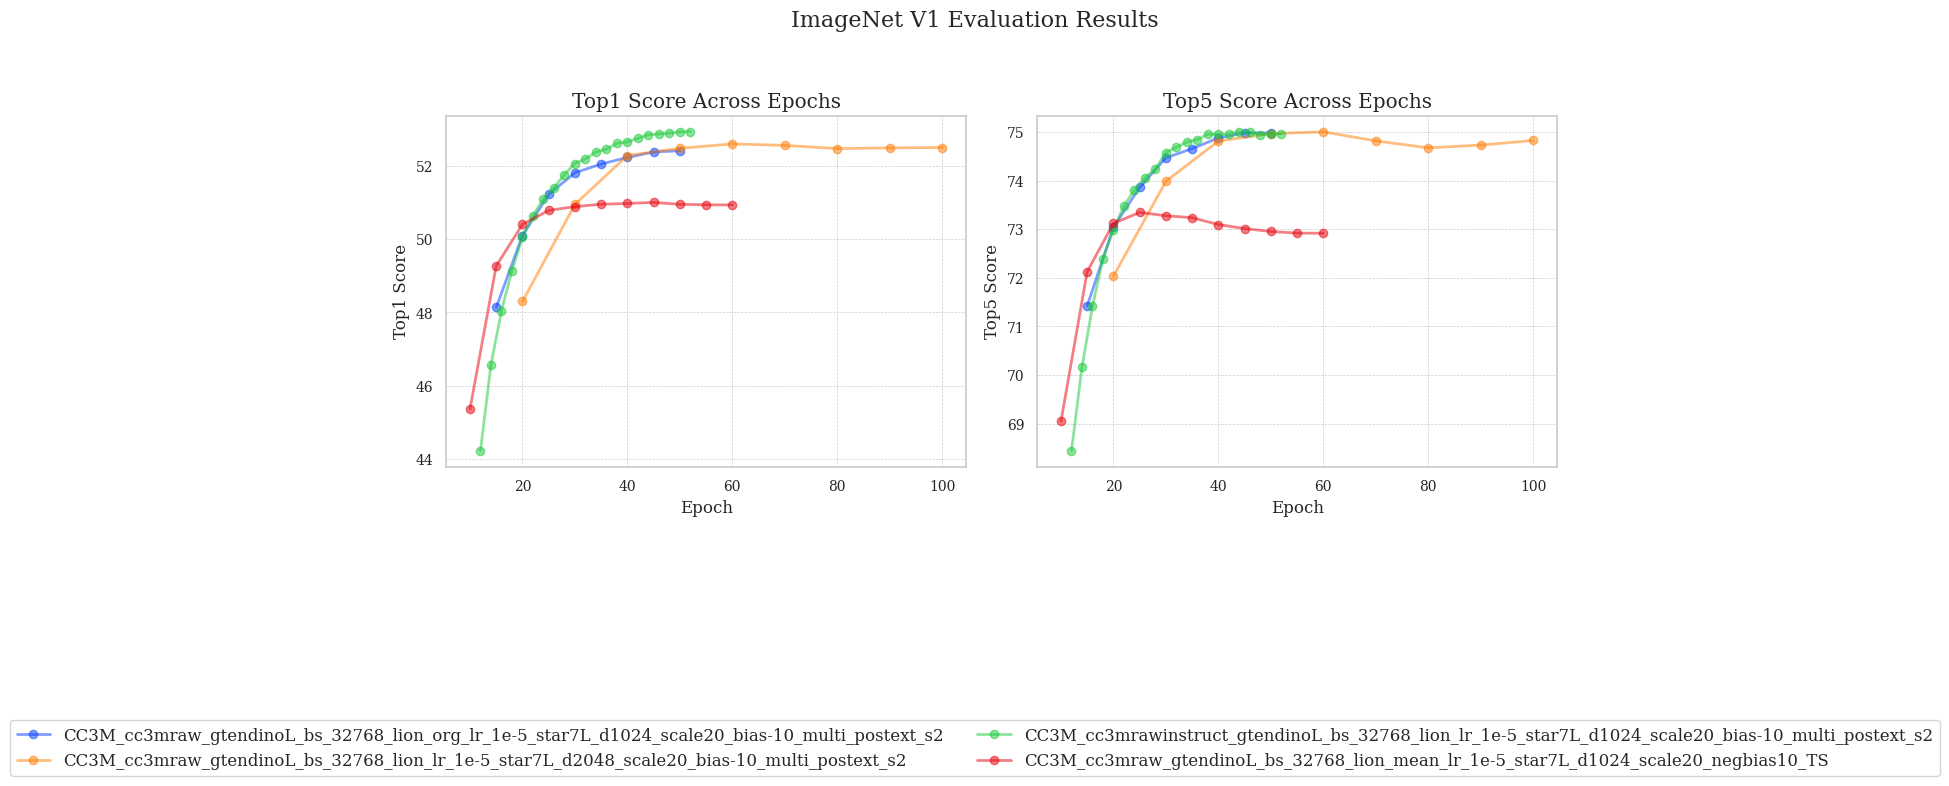

In [18]:
def extract_epoch_and_scores(data):
    epochs, top1_scores, top5_scores = [], [], []
    for epoch, metrics in data.items():
        epochs.append(int(epoch.split('_')[1]))
        top1_scores.append(metrics['top1'])
        top5_scores.append(metrics['top5'])
    begin_epoch = min(1,len(epochs))
    epochs = epochs[begin_epoch:]
    top1_scores = top1_scores[begin_epoch:]
    top5_scores = top5_scores[begin_epoch:]
    return zip(*sorted(zip(epochs, top1_scores, top5_scores)))

def plot_imagenet_result(json_files):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    all_labels, all_handles = [], []

    for json_file in json_files:
        data = read_json_file(json_file)
        if data is None:
            continue
        try:
            epochs, top1_scores, top5_scores = extract_epoch_and_scores(data)
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
            continue
        
        # Set different line styles for CC3M and CC12M
        model_prefix = json_file.split('/')[-2] + '_'
        data_amount = "CC3M" if "cc3m" in json_file else "CC12M"
        label = f"{data_amount}_{model_prefix + os.path.basename(json_file).replace('.json', '')}"
        linestyle = '-' if data_amount == "CC3M" else '--'
        # Set transparency for CC3M
        alpha = 0.5 if data_amount == "CC3M" else 1.0
        marker = get_marker_by_text_model(json_file)
        
        handle1, = ax1.plot(epochs, top1_scores, label=label, linestyle=linestyle, alpha=alpha, marker=marker, markersize=ms)
        handle2, = ax2.plot(epochs, top5_scores, label=label, linestyle=linestyle, alpha=alpha, marker=marker, markersize=ms)

        all_labels.append(label)
        all_handles.append(handle1)  # Handles from any of the axes would work

    # 添加水平虚线
    # ax1.axhline(67, color='r', linestyle='dashed', label='Baseline Top1')


    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Top1 Score')
    ax1.set_title('Top1 Score Across Epochs')
    ax1.grid(True)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Top5 Score')
    ax2.set_title('Top5 Score Across Epochs')
    ax2.grid(True)

    # 在图的下方创建图例，避免与图表重叠
    fig.legend(all_handles, all_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.5))
    fig.suptitle('ImageNet V1 Evaluation Results', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()
directory = '/home/mila/l/le.zhang/scratch/light_align/evaluation/eval_result/imagenetv1/*'
json_files = filter_json_files(directory, included_keys, excluded_keys, must_include)
plot_imagenet_result(json_files)


## Imagenet V2

In [3]:

# def extract_epoch_and_scores(data):
#     epochs, top1_scores, top5_scores = [], [], []
#     for epoch, metrics in data.items():
#         epochs.append(int(epoch.split('_')[1]))
#         top1_scores.append(metrics['top1'])
#         top5_scores.append(metrics['top5'])
#     begin_index = 0
#     begin_epoch = min(begin_index,len(epochs))
#     end_epoch = min(6,len(epochs))
#     epochs = epochs[begin_epoch:end_epoch]
#     top1_scores = top1_scores[begin_epoch:end_epoch]
#     top5_scores = top5_scores[begin_epoch:end_epoch]
#     return zip(*sorted(zip(epochs, top1_scores, top5_scores)))

# def plot_imagenet_result(json_files):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#     all_labels, all_handles = [], []

#     for json_file in json_files:
#         data = read_json_file(json_file)
#         if data is None:
#             continue
#         try:
#             epochs, top1_scores, top5_scores = extract_epoch_and_scores(data)
#         except Exception as e:
#             print(f"Error processing {json_file}: {e}")
#             continue
        
#         model_prefix = json_file.split('/')[-2] + '_'
#         # Set different line styles for CC3M and CC12M
#         model_prefix = json_file.split('/')[-2] + '_'
#         data_amount = "CC3M" if "cc3m" in json_file else "CC12M"
#         label = f"{data_amount}_{model_prefix + os.path.basename(json_file).replace('.json', '')}"
#         linestyle = '-' if data_amount == "CC3M" else '--'
#         # Set transparency for CC3M
#         alpha = 0.5 if data_amount == "CC3M" else 1.0

#         marker = get_marker_by_text_model(model_prefix)
#         handle1, = ax1.plot(epochs, top1_scores, label=label, linestyle=linestyle, alpha=alpha, marker=marker, markersize=ms)
#         handle2, = ax2.plot(epochs, top5_scores, label=label, linestyle=linestyle, alpha=alpha, marker=marker, markersize=ms)

#         all_labels.append(label)
#         all_handles.append(handle1)  # Handles from any of the axes would work

#     # 添加水平虚线
#     # ax1.axhline(55.93, color='r', linestyle='dashed', label='Baseline Top1')
#     # ax2.axhline(83.36, color='r', linestyle='dashed', label='Baseline Top5')

#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Top1 Score')
#     ax1.set_title('Top1 Score Across Epochs')
#     ax1.grid(True)

#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Top5 Score')
#     ax2.set_title('Top5 Score Across Epochs')
#     ax2.grid(True)

#     # 在图的下方创建图例，避免与图表重叠
#     fig.legend(all_handles, all_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.5))
#     # Add a general title for the entire figure
#     fig.suptitle('ImageNet V2 Evaluation Results', fontsize=16, y=1.05)
#     plt.tight_layout()
#     plt.show()

# # 示例用法
# directory = '/home/mila/l/le.zhang/scratch/light_align/evaluation/eval_result/imagenetv2/*'
# json_files = filter_json_files(directory, included_keys, excluded_keys, must_include)
# plot_imagenet_result(json_files)


In [4]:
# import os
# import json
# import matplotlib.pyplot as plt
# import glob

# def plot_winoground_result(json_files):
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

#     all_labels = []
#     all_handles = []

#     for json_file in json_files:
#         data = read_json_file(json_file)
#         if data is None:
#             continue

#         epochs = []
#         image_score = []
#         text_score = []
#         group_score = []

#         for epoch, metrics in data.items():
#             epochs.append(int(epoch.split('_')[1]))
#             image_score.append(metrics['image'] * 100)
#             text_score.append(metrics['text'] * 100)
#             group_score.append(metrics['group'] * 100)

#         # 按照 epoch 排序
#         model_prefix = json_file.split('/')[-2] + '_'
#         epochs, image_score, text_score, group_score = zip(*sorted(zip(epochs, image_score, text_score, group_score)))

#         ax1.hlines(30.75, xmin=epochs[0], xmax=epochs[-1], colors='r', linestyles='dashed')
#         ax2.hlines(11.25, xmin=epochs[0], xmax=epochs[-1], colors='r', linestyles='dashed')
#         ax3.hlines(8.75, xmin=epochs[0], xmax=epochs[-1], colors='r', linestyles='dashed')

#         label = f"{model_prefix + os.path.basename(json_file).replace('.json', '')}"
#         handle1, = ax1.plot(epochs, text_score, label=label)
#         handle2, = ax2.plot(epochs, image_score, label=label)
#         handle3, = ax3.plot(epochs, group_score, label=label)

#         all_labels.append(label)
#         all_handles.append(handle1)  # Handles from any of the axes would work

#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Text Score')
#     ax1.set_title('Text Score Across Epochs')
#     ax1.grid(True)

#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Image Score')
#     ax2.set_title('Image Score Across Epochs')
#     ax2.grid(True)

#     ax3.set_xlabel('Epoch')
#     ax3.set_ylabel('Group Score')
#     ax3.set_title('Group Score Across Epochs')
#     ax3.grid(True)

#     # Create a single legend for all subplots
#     fig.legend(all_handles, all_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.2))

#     plt.tight_layout()
#     plt.show()

# json_files = directory='/home/mila/l/le.zhang/scratch/light_align/evaluation/eval_result/winoground/*'


# json_files = filter_json_files(directory, included_keys, excluded_keys, must_include)
# plot_winoground_result(json_files)


# COCO

/home/mila/l/le.zhang/scratch/light_align/evaluation/eval_result/COCO/cc3mraw_gtendinoL/bs_32768_lion_mean_lr_1e-5_star7L_d1024_scale20_negbias10_TS.json


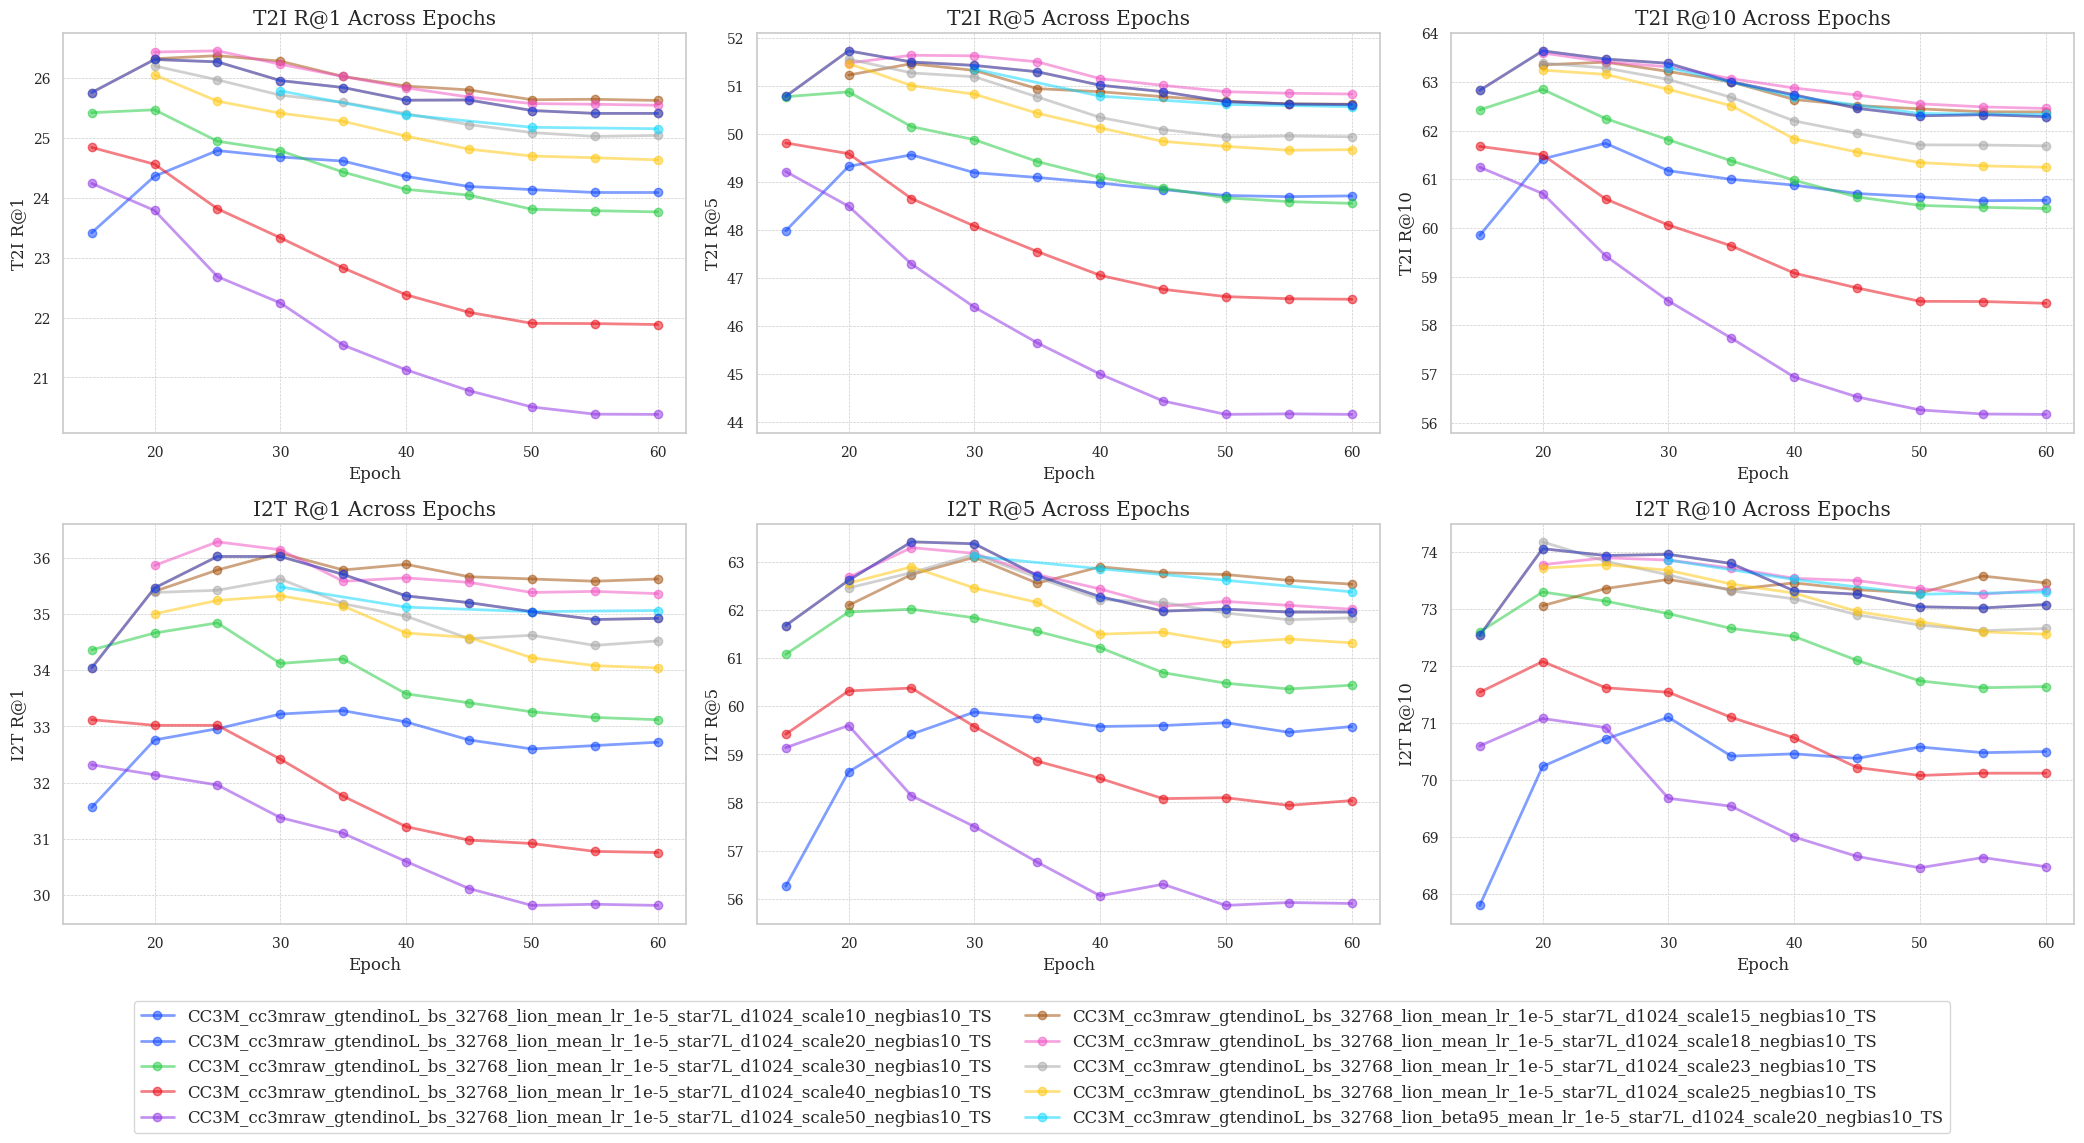

In [5]:
import os
import json
import matplotlib.pyplot as plt
import glob


def plot_coco_result(json_files):
    metrics_to_plot = ["T2I R@1", "T2I R@5", "T2I R@10", "I2T R@1", "I2T R@5", "I2T R@10"]
    CLIPB32 = [30.4, 54.75, 66.1, 50, 74.9, 83.24]
    CLIPL14 = [37.68, 62.10, 71.87, 56.26, 80.22, 87.32]
    num_metrics = len(metrics_to_plot) // 2
    fig, axes = plt.subplots(2, num_metrics, figsize=(7 * num_metrics, 10))

    all_labels = []
    all_handles = []

    for json_file in json_files:
        data = read_json_file(json_file)
        if data is None:
            continue

        epochs = sorted([int(epoch.split('_')[1]) for epoch in data.keys()])[2:][:12]

        for i, metric in enumerate(metrics_to_plot):
            scores = [data[f'epoch_{epoch}'][metric] * 100 for epoch in epochs]
            row, col = divmod(i, num_metrics)
            ax = axes[row, col]
            model_prefix = json_file.split('/')[-2] + '_'
            
            
            
            # Set different line styles for CC3M and CC12M
            model_prefix = json_file.split('/')[-2] + '_'
            data_amount = "CC3M" if "cc3m" in json_file else "CC12M"
            label = f"{data_amount}_{model_prefix + os.path.basename(json_file).replace('.json', '')}"
            linestyle = '-' if data_amount == "CC3M" else '--'
            # Set transparency for CC3M
            alpha = 0.5 if data_amount == "CC3M" else 1.0

            text_model = "gte" if "gte" in json_file else "Qwen"
            # different dot style for different text model
            marker = get_marker_by_text_model(json_file)
            handle, = ax.plot(epochs, scores, label=label, linestyle=linestyle, alpha=alpha, marker=marker, markersize=ms)

          
            
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric)
            ax.set_title(f'{metric} Across Epochs')
            # ax.hlines(CLIPB32[i], xmin=epochs[0], xmax=epochs[-1], colors='r', linestyles=':', label='CLIPB32' if i == 0 else "")
            # ax.hlines(CLIPL14[i], xmin=epochs[0], xmax=epochs[-1], colors='b', linestyles=':', label='CLIPL14' if i == 0 else "")

            ax.grid(True)

            all_labels.append(label)
            all_handles.append(handle)

    # Remove duplicate handles and labels
    handles_labels = {h.get_label(): h for h in all_handles}
    unique_handles = list(handles_labels.values())
    unique_labels = list(handles_labels.keys())

    # Create a single legend for all subplots and place it at the bottom
    fig.legend(unique_handles, unique_labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))

    plt.tight_layout()
    plt.show()

directory='/home/mila/l/le.zhang/scratch/light_align/evaluation/eval_result/COCO/*'


json_files = filter_json_files(directory, included_keys, excluded_keys, must_include)
plot_coco_result(json_files)


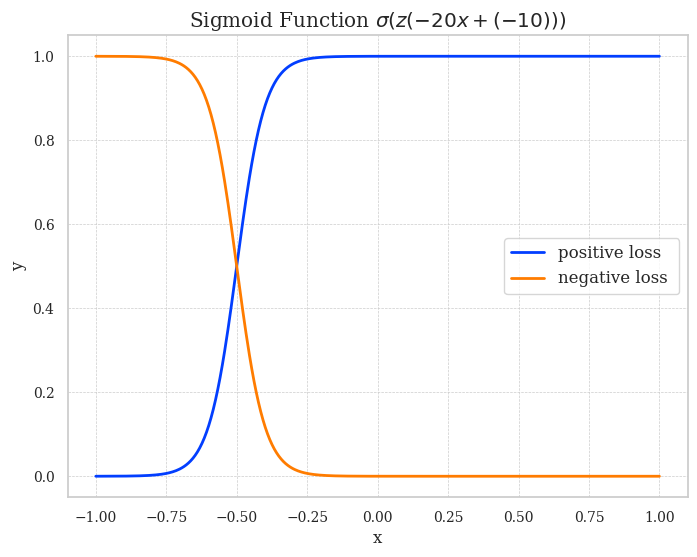

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
t = 20
b = -10

# Generate x values in the range [-1, 1]
x = np.linspace(-1, 1, 500)

# Calculate y values for sigmoid(- (t * x + b))
y_pos = 1 / (1 + np.exp((-t * x + b)))
y_neg = 1 / (1 + np.exp(-(-t * x + b)))
# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(x, y_pos, label=r'positive loss ')
plt.plot(x, y_neg, label=r'negative loss ')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Sigmoid Function $\sigma(z(-20x + (-10)))$')
plt.grid(True)
plt.legend()
plt.show()


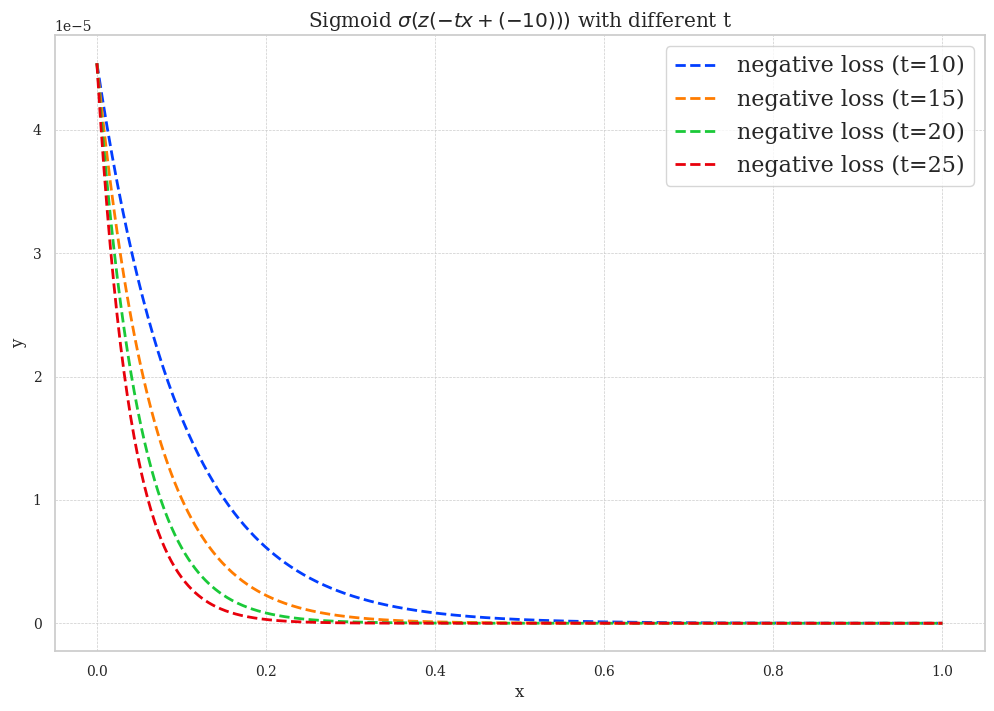

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
b = -10
t_values = [10, 15, 20, 25]

# 生成x值范围 [-1, 1]
x = np.linspace(0, 1, 500)

# 创建图形
plt.figure(figsize=(12, 8))

# 为每个t值绘制正负损失曲线
for t in t_values:
    y_pos = 1 / (1 + np.exp((-t * x + b)))
    y_neg = 1 / (1 + np.exp(-(-t * x + b)))
    
    # plt.plot(x, y_pos, label=f'positive loss (t={t})')
    plt.plot(x, y_neg, label=f'negative loss (t={t})', linestyle='--')

plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Sigmoid $\sigma(z(-tx + (-10)))$ with different t')
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

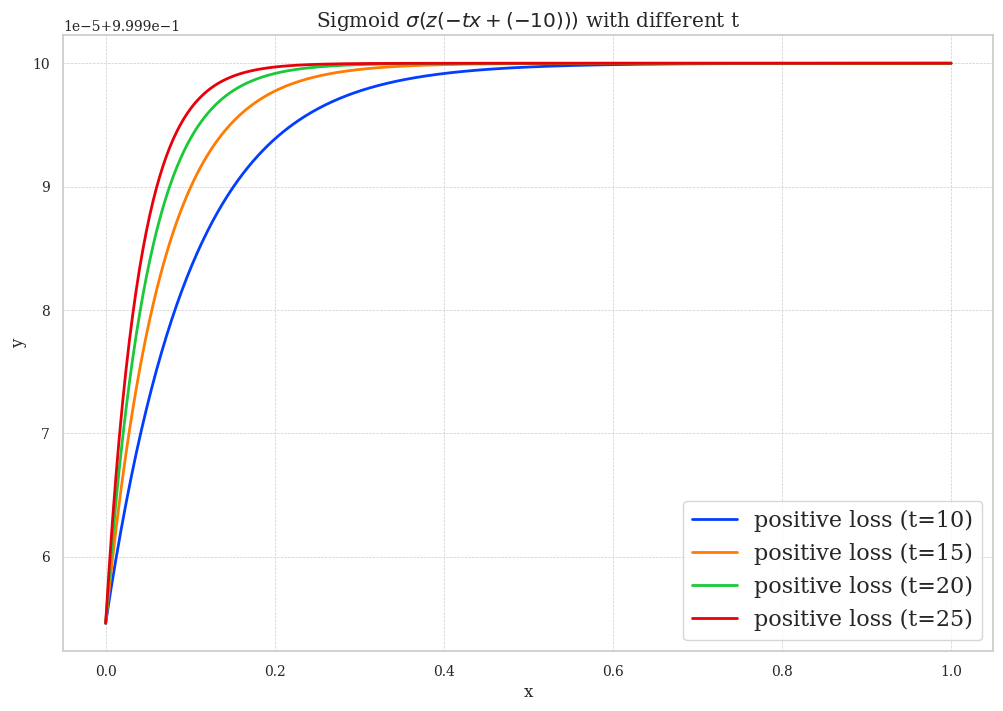

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
b = -10
t_values = [10, 15, 20, 25]

# 生成x值范围 [-1, 1]
x = np.linspace(0, 1, 500)

# 创建图形
plt.figure(figsize=(12, 8))

# 为每个t值绘制正负损失曲线
for t in t_values:
    y_pos = 1 / (1 + np.exp((-t * x + b)))
    y_neg = 1 / (1 + np.exp(-(-t * x + b)))
    
    plt.plot(x, y_pos, label=f'positive loss (t={t})')
    # plt.plot(x, y_neg, label=f'negative loss (t={t})', linestyle='--')

plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Sigmoid $\sigma(z(-tx + (-10)))$ with different t')
plt.grid(True)
plt.legend(fontsize=16)
plt.show()